In [ ]:
!pip install noisereduce torchaudio scipy matplotlib --quiet

In [ ]:
import numpy as np
import torch
import torchaudio
import scipy.signal as signal
import noisereduce as nr
import matplotlib.pyplot as plt
import os



In [ ]:
def align_and_clip_start_times(path1, path2, sr=16000):
    # 1. Load the raw files
    w1, _ = torchaudio.load(path1)
    w2, _ = torchaudio.load(path2)

    # 2. Find the Offset (The Global Snap)
    # Using first 10 seconds for math efficiency
    check_len = 10 * sr
    a = w1[0, :check_len].numpy()
    b = w2[0, :check_len].numpy()

    # Normalize for cross-correlation accuracy
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)

    corr = np.correlate(a, b, mode='full')
    lags = np.arange(-len(a) + 1, len(a))
    offset = lags[np.argmax(corr)]

    print(f"🎯 Offset Found: {offset} samples ({(offset/sr)*1000:.2f} ms)")

    # 3. CLIP THE START TIMES
    if offset > 0:
        w1_clipped = w1[:, offset:]
        w2_clipped = w2[:, :w1_clipped.shape[1]]
    else:
        w2_clipped = w2[:, abs(offset):]
        w1_clipped = w1[:, :w2_clipped.shape[1]]

    min_len = min(w1_clipped.shape[1], w2_clipped.shape[1])
    w1_final = w1_clipped[:, :min_len]
    w2_final = w2_clipped[:, :min_len]

    print(f"✅ Alignment complete. Final length: {min_len} samples.")
    return w1_final, w2_final

In [ ]:

import scipy.signal as signal
import noisereduce as nr
import gc
from tqdm import tqdm  # This will give us a visual progress bar

def denoise_audio_spatially(tensor, sr=16000, chunk_sec=30, overlap_sec=1):
    """
    Cleans audio in memory-safe chunks using a Zero-Phase filter and Spectral Gating.
    """
    # 1. Setup
    data = tensor.numpy()
    if data.ndim > 1:
        data = data[0]
    data = data.squeeze()
    total_samples = len(data)

    chunk_size = chunk_sec * sr
    overlap_size = overlap_sec * sr

    # Pre-calculate the Zero-Phase filter
    sos = signal.butter(6, [80, 7500], btype='bandpass', fs=sr, output='sos')

    processed_chunks = []


    # 2. Chunking Loop
    for start_idx in tqdm(range(0, total_samples, chunk_size), desc="Denoising"):
        # A. Calculate bounds with overlap padding
        read_start = max(0, start_idx - overlap_size)
        read_end = min(total_samples, start_idx + chunk_size + overlap_size)

        # B. Extract the padded chunk
        chunk = data[read_start:read_end]

        # --- Part A: Zero-Phase Bandpass ---
        filtered_chunk = signal.sosfiltfilt(sos, chunk)

        # --- Part B: Spectral Gating ---
        cleaned_chunk = nr.reduce_noise(
            y=filtered_chunk,
            sr=sr,
            stationary=True,
            prop_decrease=0.8,
            n_jobs=1
        )

        # C. Trim the overlap off
        trim_front = start_idx - read_start
        valid_len = min(chunk_size, total_samples - start_idx)
        final_chunk = cleaned_chunk[trim_front : trim_front + valid_len]
        processed_chunks.append(final_chunk)

        # Clear memory
        del chunk, filtered_chunk, cleaned_chunk
        gc.collect()

    # 3. Re-stitch the timeline
    print("✅ Loop finished. Re-stitching chunks...")
    final_audio = np.concatenate(processed_chunks)

    print("✅ Re-stitching complete. Returning tensor to main script...")
    return torch.from_numpy(final_audio).float().unsqueeze(0)

In [ ]:
import matplotlib.pyplot as plt

def visualize_comparison(raw, clean, sr=16000, snippet_sec=120):
    print("📊 --- VISUALIZER DIAGNOSTICS ---")
    print(f"   RAW shape: {raw.shape}")
    print(f"   CLEAN shape: {clean.shape}")

    if raw.shape[-1] != clean.shape[-1]:
        print("🚨 WARNING: Length mismatch detected! Your alignment might be off.")
    else:
        print("✅ Lengths match perfectly. Spatial map and IPDs are secure.")

    print("🧹 Step 1: Clearing deadlocked plots from background...")
    plt.close('all')

    print(f"✂️ Step 2: Slicing the first {snippet_sec} seconds for speed...")
    num_samples = sr * snippet_sec

    # 🚨 THE FIX 🚨
    # If RAW is stereo [2, Time], grab Channel 0, then slice Time
    if raw.dim() > 1:
        raw_plot = raw[0, :num_samples].numpy()
    else:
        raw_plot = raw[:num_samples].numpy()

    # CLEAN is mono [1, Time]. Squeeze makes it [Time], then slice.
    clean_plot = clean.squeeze()[:num_samples].numpy()

    print(f"   -> RAW slice shape: {raw_plot.shape}")
    print(f"   -> CLEAN slice shape: {clean_plot.shape}")

    print("🖼️ Step 3: Initializing Matplotlib canvas...")
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))

    print("📈 Step 4: Plotting RAW Waveform...")
    axs[0, 0].set_title("RAW Waveform")
    axs[0, 0].plot(raw_plot, color='gray', alpha=0.5)

    print("🌈 Step 5: Plotting RAW Spectrogram (Heavy math)...")
    axs[0, 1].set_title("RAW Spectrogram")
    axs[0, 1].specgram(raw_plot, Fs=sr, NFFT=512, noverlap=256, cmap='magma')

    print("📈 Step 6: Plotting CLEAN Waveform...")
    axs[1, 0].set_title("CLEANED Waveform")
    axs[1, 0].plot(clean_plot, color='blue')

    print("🌈 Step 7: Plotting CLEAN Spectrogram (Heavy math)...")
    axs[1, 1].set_title("CLEANED Spectrogram")
    axs[1, 1].specgram(clean_plot, Fs=sr, NFFT=512, noverlap=256, cmap='magma')

    print("📐 Step 8: Adjusting layout...")
    plt.tight_layout()

    print("🚀 Step 9: Pushing image to screen...")
    plt.show()
    print("✅ Visualization complete!")

# Run it
# visualize_comparison(w1_aligned, w1_clean)

In [ ]:
import os
import glob
import torchaudio # Or librosa, depending on your clipped function requirements
from google.colab import drive

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the path to your session folder
# Based on your directory structure: My Drive/GEEKED/Audio_Files/Session_003/
session_dir = "/content/drive/My Drive/GEEKED/Audio_Files/Session_003/"

# 3. Dynamically find the doctor and patient files
try:
    doctor_path = glob.glob(os.path.join(session_dir, "Doctor*"))[0]
    patient_path = glob.glob(os.path.join(session_dir, "Patient*"))[0]

    print(f"Found Doctor file: {os.path.basename(doctor_path)}")
    print(f"Found Patient file: {os.path.basename(patient_path)}")

    # 4. Load the files (using 16k sample rate as noted in your research )
    doctor_audio, sr = torchaudio.load(doctor_path)
    patient_audio, _ = torchaudio.load(patient_path)

except IndexError:
    print("Error: Could not find files starting with 'doctor' or 'patient' in the specified directory.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found Doctor file: Doctor_20250223-140422.wav
Found Patient file: Patient_20250223-140422.wav


🎯 Offset Found: 1171 samples (73.19 ms)
✅ Alignment complete. Final length: 4007405 samples.
🔄 Processing 4007405 samples (250.46s) in 30s chunks...


Denoising: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
🔄 Processing 4007405 samples (250.46s) in 30s chunks...


Denoising: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
📊 --- VISUALIZER DIAGNOSTICS ---
   RAW shape: torch.Size([2, 4007405])
   CLEAN shape: torch.Size([1, 4007405])
✅ Lengths match perfectly. Spatial map and IPDs are secure.
🧹 Step 1: Clearing deadlocked plots from background...
✂️ Step 2: Slicing the first 120 seconds for speed...
   -> RAW slice shape: (1920000,)
   -> CLEAN slice shape: (1920000,)
🖼️ Step 3: Initializing Matplotlib canvas...
📈 Step 4: Plotting RAW Waveform...
🌈 Step 5: Plotting RAW Spectrogram (Heavy math)...
📈 Step 6: Plotting CLEAN Waveform...
🌈 Step 7: Plotting CLEAN Spectrogram (Heavy math)...
📐 Step 8: Adjusting layout...
🚀 Step 9: Pushing image to screen...


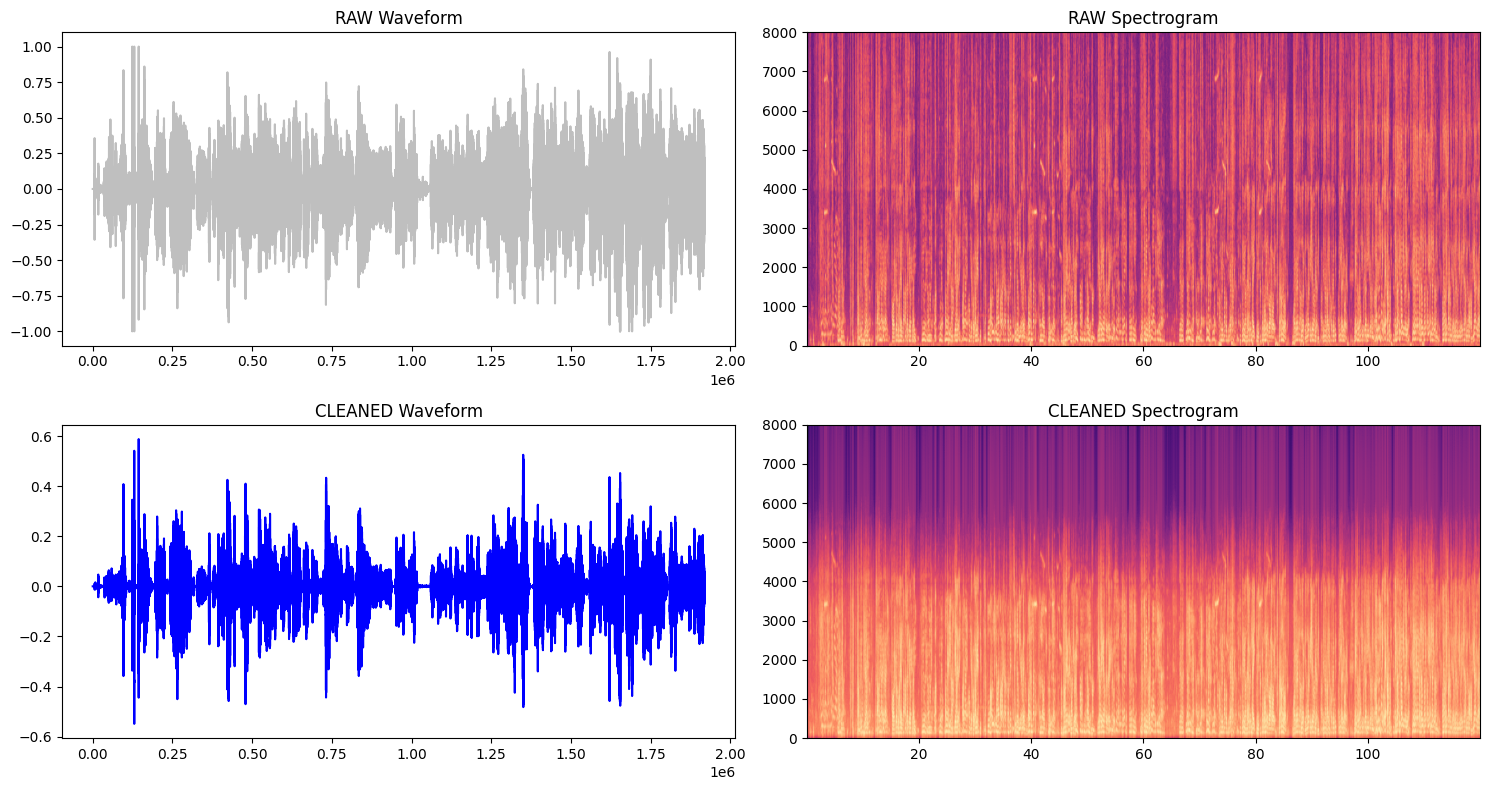

✅ Visualization complete!


In [ ]:
# 1. Align the files
w1_aligned, w2_aligned = align_and_clip_start_times(doctor_path, patient_path)

# 2. Denoise each track individually
# (We clean them separately so their unique room noises are handled properly)
w1_clean = denoise_audio_spatially(w1_aligned)
w2_clean = denoise_audio_spatially(w2_aligned)

# 3. Visualize the Doctor's track to check clarity
visualize_comparison(w1_aligned, w1_clean)

# 4. Save the results
torchaudio.save("Doc_Clean_Final.wav", w1_clean, 16000)
torchaudio.save("Pat_Clean_Final.wav", w2_clean, 16000)

In [ ]:
import os
import torchaudio

# 1. Extract the folder paths and original filenames
doc_dir = os.path.dirname(doctor_path)
doc_name = os.path.basename(doctor_path)

pat_dir = os.path.dirname(patient_path)
pat_name = os.path.basename(patient_path)

# 2. Create the new filenames (assuming they end in .wav)
doc_save_name = doc_name.replace('.wav', '_Cleaned2.wav')
pat_save_name = pat_name.replace('.wav', '_Cleaned2.wav')

# 3. Construct the final save paths in the original folders
doc_save_path = os.path.join(doc_dir, doc_save_name)
pat_save_path = os.path.join(pat_dir, pat_save_name)

# 4. Save the files
print(f"💾 Saving clean Doctor track to: {doc_save_path}")
torchaudio.save(doc_save_path, w1_clean, 16000)

print(f"💾 Saving clean Patient track to: {pat_save_path}")
torchaudio.save(pat_save_path, w2_clean, 16000)

print("✅ Files successfully saved alongside the originals!")

💾 Saving clean Doctor track to: /content/drive/My Drive/GEEKED/Audio_Files/Session_003/Doctor_20250223-140422_Cleaned2.wav
💾 Saving clean Patient track to: /content/drive/My Drive/GEEKED/Audio_Files/Session_003/Patient_20250223-140422_Cleaned2.wav
✅ Files successfully saved alongside the originals!


In [ ]:
base_dir = "/content/drive/My Drive/GEEKED/Audio_Files/"
session_folders = sorted(glob.glob(os.path.join(base_dir, "Session_*")))

print(f"\n📂 FOUND {len(session_folders)} SESSION FOLDERS.")
if len(session_folders) == 0:
    print("❌ Error: Could not find any folders matching 'Session_*'. Check your Drive path!")

for session_path in session_folders:
    session_name = os.path.basename(session_path)
    print(f"\n🚀 --- Starting {session_name} ---")

    # 1. Find the raw files
    doc_files = glob.glob(os.path.join(session_path, "*Doc*.wav"))
    pat_files = glob.glob(os.path.join(session_path, "*Pat*.wav"))

    # Ignore anything we already cleaned
    doc_raw = [f for f in doc_files if "clean" not in f.lower()]
    pat_raw = [f for f in pat_files if "clean" not in f.lower()]

    if not doc_raw or not pat_raw:
        print(f"⚠️ Skipping {session_name}: Missing raw doc/pat files or already cleaned.")
        continue

    doc_path = doc_raw[0]
    pat_path = pat_raw[0]

    print(f"   ✂️ Aligning files...")
    w1_aligned, w2_aligned = align_and_clip_start_times(doc_path, pat_path)

    print(f"   🧹 Cleaning Doctor track...")
    w1_clean = denoise_audio_spatially(w1_aligned)

    print(f"   🧹 Cleaning Patient track...")
    w2_clean = denoise_audio_spatially(w2_aligned)

    # 2. Save directly into the session folder
    doc_save_path = os.path.join(session_path, "doc_clean.wav")
    pat_save_path = os.path.join(session_path, "pat_clean.wav")

    torchaudio.save(doc_save_path, w1_clean, 16000)
    torchaudio.save(pat_save_path, w2_clean, 16000)

    print(f"   ✅ Saved to {session_name}!")

    # 3. Flush RAM for the next session
    del w1_aligned, w2_aligned, w1_clean, w2_clean
    gc.collect()

print("\n🎉 ALL SESSIONS PROCESSED AND SAVED!")


📂 FOUND 10 SESSION FOLDERS.

🚀 --- Starting Session_001 ---
   ✂️ Aligning files...
🎯 Offset Found: 587 samples (36.69 ms)
✅ Alignment complete. Final length: 5540480 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 5540480 samples (346.28s) in 30s chunks...


Denoising: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 5540480 samples (346.28s) in 30s chunks...


Denoising: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_001!

🚀 --- Starting Session_002 ---
   ✂️ Aligning files...
🎯 Offset Found: 1045 samples (65.31 ms)
✅ Alignment complete. Final length: 4785259 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 4785259 samples (299.08s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 4785259 samples (299.08s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_002!

🚀 --- Starting Session_003 ---
   ✂️ Aligning files...
🎯 Offset Found: 1171 samples (73.19 ms)
✅ Alignment complete. Final length: 4007405 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 4007405 samples (250.46s) in 30s chunks...


Denoising: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 4007405 samples (250.46s) in 30s chunks...


Denoising: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_003!

🚀 --- Starting Session_004 ---
   ✂️ Aligning files...
🎯 Offset Found: -47 samples (-2.94 ms)
✅ Alignment complete. Final length: 5962961 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 5962961 samples (372.69s) in 30s chunks...


Denoising: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 5962961 samples (372.69s) in 30s chunks...


Denoising: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_004!

🚀 --- Starting Session_005 ---
   ✂️ Aligning files...
🎯 Offset Found: 1018 samples (63.62 ms)
✅ Alignment complete. Final length: 4575238 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 4575238 samples (285.95s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 4575238 samples (285.95s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_005!

🚀 --- Starting Session_006 ---
   ✂️ Aligning files...
🎯 Offset Found: -8603 samples (-537.69 ms)
✅ Alignment complete. Final length: 3231488 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 3231488 samples (201.97s) in 30s chunks...


Denoising: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 3231488 samples (201.97s) in 30s chunks...


Denoising: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_006!

🚀 --- Starting Session_007 ---
   ✂️ Aligning files...
🎯 Offset Found: 70 samples (4.38 ms)
✅ Alignment complete. Final length: 4963386 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 4963386 samples (310.21s) in 30s chunks...


Denoising: 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 4963386 samples (310.21s) in 30s chunks...


Denoising: 100%|██████████| 11/11 [00:06<00:00,  1.68it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_007!

🚀 --- Starting Session_008 ---
   ✂️ Aligning files...
🎯 Offset Found: 12113 samples (757.06 ms)
✅ Alignment complete. Final length: 4760367 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 4760367 samples (297.52s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 4760367 samples (297.52s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_008!

🚀 --- Starting Session_009 ---
   ✂️ Aligning files...
🎯 Offset Found: 944 samples (59.00 ms)
✅ Alignment complete. Final length: 5687888 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 5687888 samples (355.49s) in 30s chunks...


Denoising: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 5687888 samples (355.49s) in 30s chunks...


Denoising: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_009!

🚀 --- Starting Session_010 ---
   ✂️ Aligning files...
🎯 Offset Found: 887 samples (55.44 ms)
✅ Alignment complete. Final length: 4632329 samples.
   🧹 Cleaning Doctor track...
🔄 Processing 4632329 samples (289.52s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   🧹 Cleaning Patient track...
🔄 Processing 4632329 samples (289.52s) in 30s chunks...


Denoising: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


✅ Loop finished. Re-stitching chunks...
✅ Re-stitching complete. Returning tensor to main script...
   ✅ Saved to Session_010!

🎉 ALL SESSIONS PROCESSED AND SAVED!
